In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_parquet('Data\process_taxis.parquet',engine='pyarrow')

In [3]:
df['trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds()

In [4]:
df.tail(3)

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,total_price,service,trip_duration
57785405,2024-07-01 00:05:23,2024-07-01 00:15:02,5.0,2.07,263,151,26.70,0,579.0
57785406,2026-06-26 23:26:55,2026-06-26 23:47:51,1.0,10.96,138,233,85.25,0,1256.0
57785407,2026-06-26 23:53:12,2026-06-27 20:59:10,1.0,0.56,233,264,16.20,0,75958.0


Para observar una distribucion mas representativa de los datos, se filtraran los datos por los cuartiles, pero para lograr una mayor sensibilidad a valores extremos, se extenderan los cuartiles para dejar datos por encima del %10 hasta el 90%

In [5]:
Q1_trip_distance = df['trip_distance'].quantile(0.10)
Q3_trip_distance = df['trip_distance'].quantile(0.90)
IQR_trip_distance = Q3_trip_distance - Q1_trip_distance
Q1_total_price = df['total_price'].quantile(0.10)
Q3_total_price = df['total_price'].quantile(0.90)
IQR_total_price = Q3_total_price - Q1_total_price
Q1_trip_duration = df['trip_duration'].quantile(0.10)
Q3_trip_duration = df['trip_duration'].quantile(0.90)
IQR_trip_duration = Q3_trip_duration - Q1_trip_duration
# df without outliers
df_withoutliers = df[~((df['trip_distance'] < (Q1_trip_distance - 1.5 * IQR_trip_distance)) | (df['trip_distance'] > (Q3_trip_distance + 1.5 * IQR_trip_distance)))]
df_withoutliers = df_withoutliers[~((df_withoutliers['total_price'] < (Q1_total_price - 1.5 * IQR_total_price)) | (df_withoutliers['total_price'] > (Q3_total_price + 1.5 * IQR_total_price)))]
df_withoutliers = df_withoutliers[~((df_withoutliers['trip_duration'] < (Q1_trip_duration - 1.5 * IQR_trip_duration)) | (df_withoutliers['trip_duration'] > (Q3_trip_duration + 1.5 * IQR_trip_duration)))]

Eliminamos las columnas con datos negativos en el precio total y la duracion del viaje.

In [6]:
df_withoutliers = df_withoutliers[df_withoutliers['total_price'] >= 0]
df_withoutliers = df_withoutliers[df_withoutliers['trip_duration'] >= 0]

Text(0.5, 1.0, 'trip_duration')

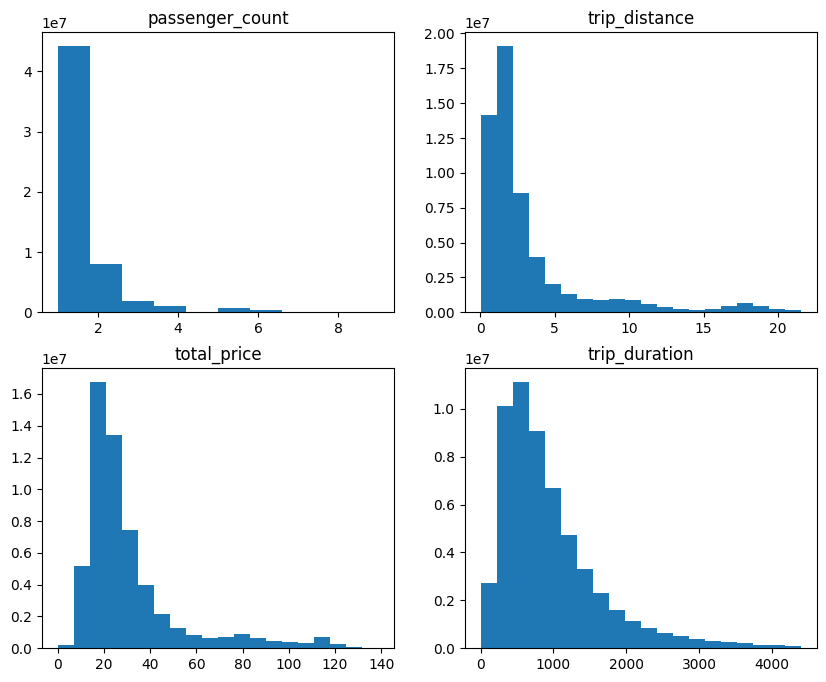

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0,0].hist(df_withoutliers['passenger_count'])
axs[0,0].set_title('passenger_count')
axs[0,1].hist(df_withoutliers['trip_distance'], bins=20)
axs[0,1].set_title('trip_distance')
axs[1,0].hist(df_withoutliers['total_price'], bins=20)
axs[1,0].set_title('total_price')
axs[1,1].hist(df_withoutliers['trip_duration'], bins=20)
axs[1,1].set_title('trip_duration')


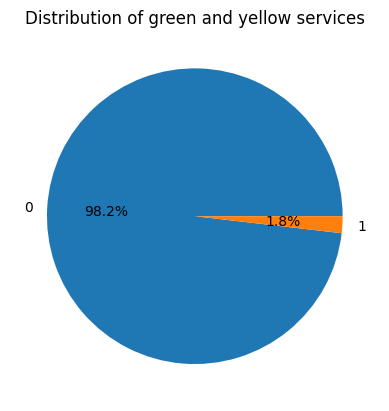

In [10]:
# Contar la frecuencia de cada categoría
counts = df['service'].value_counts()
# Crear el gráfico de pie
plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
plt.title('Distribution of green and yellow services')
plt.show()


#sns.countplot(x='Service', hue='service', data=df)